In [98]:
# Import libraries

import torch
from smagnet import SMAGNet
import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import glob
import os
import re

In [99]:
# Load the input data (SAR, MSI)

fn_sar = 'S1B_IW_GRDH_1SDV_20180215T095745_20180215T095810_009632_0115DE_7203_05557-07236_S1Hand.tif'
fn_msi = 'S1B_IW_GRDH_1SDV_20180215T095745_20180215T095810_009632_0115DE_7203_05557-07236_S2Hand.tif'
fn_label = 'S1B_IW_GRDH_1SDV_20180215T095745_20180215T095810_009632_0115DE_7203_05557-07236_S1LabelHand.tif'

def load_tif(filename, dtype=np.float32):
    """ Load a .tif file as a NumPy array """
    # get file extension
    ext = filename.split('.')[-1] 
    assert ext == "tif", "Extension of files should be *.tif"
    
    arr = tiff.imread(filename)
    
    # check array dimension
    if len(arr.shape) == 3:
        ret = arr.astype(dtype)
    elif len(arr.shape) == 2:
        ret = np.expand_dims(arr, axis=0).astype(dtype)
    else:
        raise Exception("Dimension of input file {} is not suitable. It must be 2(width, height) or 3(width, height, channel) dimension".format(file_path))
    return ret  
    
arr_sar = load_tif(fn_sar)
arr_msi = load_tif(fn_msi)
arr_label = load_tif(fn_label)

In [100]:
# Crop to 256 x 256

arr_sar = arr_sar[:,256:512, 256:512]
arr_msi = arr_msi[:,256:512, 256:512]
arr_label = arr_label[:,256:512, 256:512]

In [101]:
# Normalization
# The mean and variance of each band are computed using the training dataset.

sar_means=np.array([-11.24899382, -18.1106826]) # vv, vh
sar_stds=np.array([4.96706002, 5.66861586]) # vv, vh 
msi_means=np.array([1281.01844131, 1342.75602538, 1367.88261151, 2441.71336085]) # r, g, b, nir
msi_stds=np.array([942.61678701,  746.81006722,  716.3081281 , 1118.73538118]) # r, g, b, nir

# SAR
arr_sar = (arr_sar - sar_means[:, None, None]) / sar_stds[:, None, None] 

# Generate spatial mask
arr_msi_invalid = np.all(arr_msi == 0, axis=0)

# MSI
selected_indices = [3, 2, 1, 7] # r, g, b, nir
arr_msi = arr_msi[selected_indices]

arr_msi = (arr_msi - msi_means[:, None, None]) / msi_stds[:, None, None] # normalize

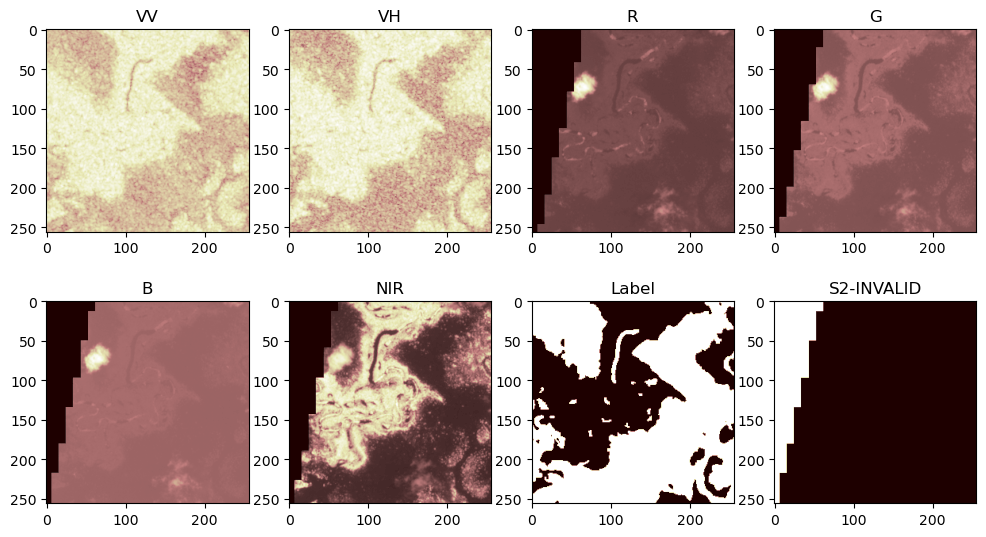

In [102]:
# Input data visualization

def show_images(arr_list, title = None, cols = 2, vmin = None, vmax = None, legend=False, figsize=(15,10)):
    """ Plots some samples from the dataset """
    num_images = len(arr_list)
    
    plt.figure(figsize=figsize) 
    for i, arr in enumerate(arr_list):
        plt.subplot(int(num_images/cols) + 1, cols, i + 1)
        if vmin is None or vmax is None:
            img = plt.imshow(arr, cmap='pink')
        else:
            img = plt.imshow(arr, cmap='pink', vmin = vmin, vmax = vmax)
        if title is not None:
            plt.title(title[i])
            
        if legend == True:
            plt.colorbar(img)
    plt.show()  
    
show_images([arr_sar[0], arr_sar[1], 
             arr_msi[0], arr_msi[1], 
             arr_msi[2], arr_msi[3], 
             arr_label[0], arr_msi_invalid], 
            title=['VV', 'VH', 'R', 'G', 'B', 'NIR', 'Label', 'S2-INVALID'], cols=4, figsize=(12,10))

In [89]:
# Initialize the SMAGNet model 

model = SMAGNet(encoder_name='resnet50', 
                encoder_weights_sar=None,
                encoder_weights_msi=None,
                classes=1,
                decoder_channels = [256, 128, 64, 32, 16],
                decoder_use_batchnorm = False,
                sarmsiff_method = 'sar_msi_gated', # sar_only, sar_msi_gated
                enable_spatial_mask = True)

enable_spatial_mask: True - OK
Sequential(
  (0): Conv2d(4096, 1, kernel_size=(1, 1), stride=(1, 1))
  (1): Sigmoid()
)
sarmsiff_method: sar_msi_gated - OK
Sequential(
  (0): Conv2d(2048, 1, kernel_size=(1, 1), stride=(1, 1))
  (1): Sigmoid()
)
sarmsiff_method: sar_msi_gated - OK
Sequential(
  (0): Conv2d(1024, 1, kernel_size=(1, 1), stride=(1, 1))
  (1): Sigmoid()
)
sarmsiff_method: sar_msi_gated - OK
Sequential(
  (0): Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
  (1): Sigmoid()
)
sarmsiff_method: sar_msi_gated - OK
Sequential(
  (0): Conv2d(128, 1, kernel_size=(1, 1), stride=(1, 1))
  (1): Sigmoid()
)
sarmsiff_method: sar_msi_gated - OK
fusion_channels: [2048, 1024, 512, 256, 64]
sarmsiff_method: sar_msi_gated
shared_decoder class: Decoder
shared_decoder channels: [256, 128, 64, 32, 16]
shared_decoder use_batchnorm: False
Complete decoder initialization.
Complete segmentation header initialization.
Complete fusion module initialization.


In [103]:
# Load the trained checkpoint

checkpoint_dir = '/path/to/checkpoint'  # Replace with your checkpoint directory
checkpoint_files = glob.glob(os.path.join(checkpoint_dir, 'smagnet_checkpoint_*.pt'))
print(f'checkpoint file: {checkpoint_files}')
assert len(checkpoint_files) == 1

checkpoint = torch.load(os.path.join(checkpoint_dir, checkpoint_files[0]), map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["model"])
                        
print("Loading model: compelte.") 
print("# of parameters : ", sum(p.numel() for p in model.parameters() if p.requires_grad))      

# Set the class threshold determined from the validation set.
hardclass_threshold = float(re.search(r'smagnet_checkpoint_(\d+\.\d+)\.pt', checkpoint_files[0]).group(1))
print(f'threshold: {hardclass_threshold}')

checkpoint file: ['/archive/projects/2025-08_SMAGNet/demo/smagnet_checkpoint_0.41648778.pt']
Loading model: compelte.
# of parameters :  56035958
threshold: 0.41648778


In [91]:
# Convert NumPy array to tensor

tensor_sar = torch.from_numpy(arr_sar).float().unsqueeze(0)
tensor_msi = torch.from_numpy(arr_msi).float().unsqueeze(0)
tensor_spatial_mask = torch.from_numpy(arr_msi_invalid).float().unsqueeze(0)

In [92]:
# Set model to evaluation mode and compute outputs

model.eval()

with torch.no_grad():
    output_sarmsiff, output_sar, skip_gate_map = model(tensor_sar, tensor_msi, tensor_spatial_mask) # output -> logit

In [93]:
# Apply sigmoid to logits, convert to NumPy array, and threshold to get binary predictions

y_prob = torch.sigmoid(output_sarmsiff)
y_prob = y_prob.squeeze().numpy()
y_pred = (y_prob > hardclass_threshold).astype(int)

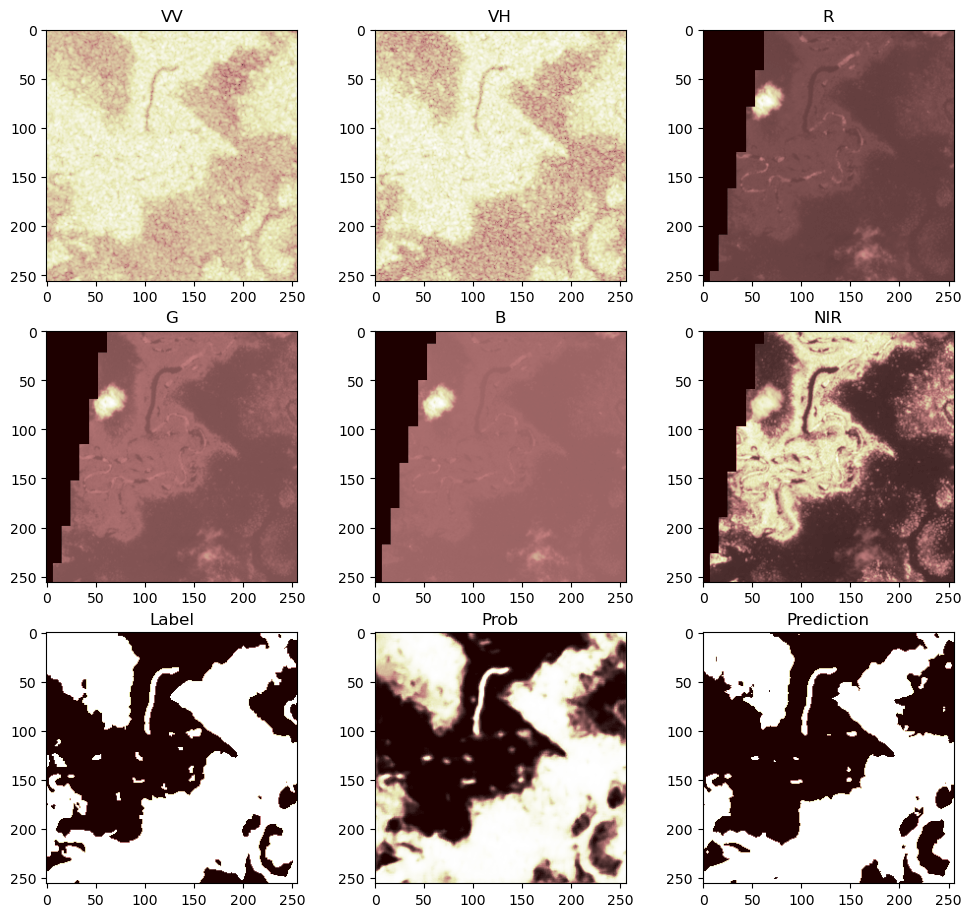

In [94]:
# Visualize the input data

show_images([arr_sar[0], arr_sar[1], arr_msi[0], 
             arr_msi[1], arr_msi[2], arr_msi[3], 
             arr_label[0], y_prob, y_pred], 
            title=['VV', 'VH', 'R', 'G', 'B', 'NIR', 'Label', 'Prob', 'Prediction'], cols=3, figsize=(12,15))

In [ ]:
# End of this example script